## DSGA 1001 - Tree Analysis (Classification)
### December 16, 2022
Code by: Leo Chen and Xinyue Ma


In [126]:
# import libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import prince
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

In [125]:
# seed the random number generator
np.random.seed(18962882)
rng = np.random.default_rng(18962882)
rs = 18962882

In [127]:
# load processed data
df = pd.read_pickle('df_alive')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 426190 entries, 1 to 683783
Data columns (total 33 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   block_id    426190 non-null  object 
 1   tree_dbh    426190 non-null  int64  
 2   curb_loc    426190 non-null  object 
 3   health      426190 non-null  int32  
 4   spc_latin   426190 non-null  object 
 5   spc_common  426190 non-null  object 
 6   steward     426190 non-null  object 
 7   guards      426190 non-null  object 
 8   sidewalk    426190 non-null  object 
 9   user_type   426190 non-null  object 
 10  problems    426190 non-null  object 
 11  root_stone  426190 non-null  object 
 12  root_grate  426190 non-null  object 
 13  root_other  426190 non-null  object 
 14  trnk_wire   426190 non-null  object 
 15  trnk_light  426190 non-null  object 
 16  trnk_other  426190 non-null  object 
 17  brnch_ligh  426190 non-null  object 
 18  brnch_shoe  426190 non-null  object 
 19  br

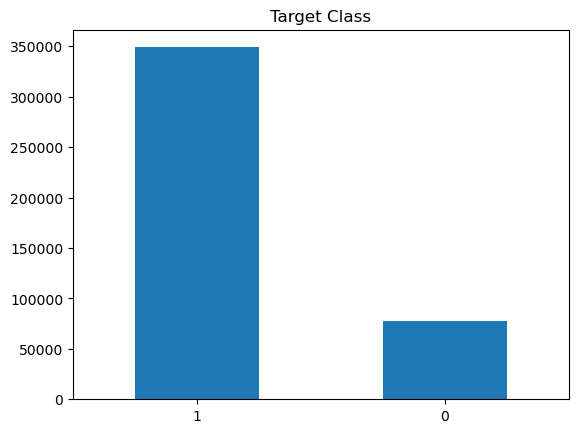

In [229]:
# Class imbalance?
df['health'].value_counts().plot(kind = 'bar')
plt.title('Target Class')
plt.xticks(rotation = 0);

#plt.savefig('Imbalanced', dpi = 200)

In [129]:
# Target
y = df['health']
y

1         0
2         1
3         1
5         1
6         1
         ..
683779    1
683780    0
683781    1
683782    1
683783    1
Name: health, Length: 426190, dtype: int32

In [163]:
# Predictors - drop target and variables with more than 10 classes
X = df.drop(columns = ['health', 'block_id', 'spc_latin', 'problems', 'zipcode', 'cb_num', 'borocode', 
                          'cncldist','st_assem','nta','nta_name','boro_ct', 'zip_city', 'st_senate'])  
X

,tree_dbh,curb_loc,spc_common,steward,guards,sidewalk,user_type,root_stone,root_grate,root_other,trnk_wire,trnk_light,trnk_other,brnch_ligh,brnch_shoe,brnch_othe,boroname,Latitude,longitude
1,21,OnCurb,pin oak,None,None,Damage,TreesCount Staff,Yes,No,No,No,No,No,No,No,No,Queens,40.794111,-73.818679
2,3,OnCurb,honeylocust,1or2,None,Damage,Volunteer,No,No,No,No,No,No,No,No,No,Brooklyn,40.717581,-73.936608
3,10,OnCurb,honeylocust,None,None,Damage,Volunteer,Yes,No,No,No,No,No,No,No,No,Brooklyn,40.713537,-73.934456
5,11,OnCurb,honeylocust,1or2,Helpful,NoDamage,Volunteer,No,No,No,No,No,No,No,No,No,Manhattan,40.770046,-73.984950
6,11,OnCurb,honeylocust,1or2,Helpful,NoDamage,Volunteer,No,No,No,No,No,No,No,No,No,Manhattan,40.770210,-73.985338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683779,27,OnCurb,London planetree,None,None,NoDamage,TreesCount Staff,Yes,No,No,Yes,No,No,Yes,No,No,Brooklyn,40.609541,-73.945835
683780,15,OnCurb,London planetree,None,Helpful,NoDamage,TreesCount Staff,No,No,No,No,No,No,No,No,No,Queens,40.746122,-73.913657
683781,20,OnCurb,pin oak,None,None,NoDamage,TreesCount Staff,Yes,No,No,No,No,No,No,No,No,Brooklyn,40.645694,-73.958179
683782,3,OnCurb,pin oak,1or2,None,NoDamage,Volunteer,No,No,No,No,No,No,No,No,No,Bronx,40.854570,-73.899192


### Clustering - Factor Analysis of Mixed Data

In [170]:
# first 20 PC
famd = prince.FAMD(
     n_components=20, 
     n_iter=3,
     copy=True,
     check_input=True,
     engine='auto',       
     random_state=rs)

famd = famd.fit(X) 

In [193]:
# first 2 only accounts for about 25%
exp_var = pd.DataFrame(famd.explained_inertia_)
exp_var.columns = ['explained_variance']
exp_var

,explained_variance
0,0.189455
1,0.114044
2,0.082753
3,0.052903
4,0.050226
5,0.046425
6,0.040383
7,0.037254
8,0.034270
9,0.031705


In [195]:
exp_var['total_explained _variance'] = exp_var['explained_variance'].cumsum()
exp_var

,explained_variance,total_explained _variance
0,0.189455,0.189455
1,0.114044,0.303500
2,0.082753,0.386253
3,0.052903,0.439155
4,0.050226,0.489382
5,0.046425,0.535807
6,0.040383,0.576190
7,0.037254,0.613444
8,0.034270,0.647714
9,0.031705,0.679419


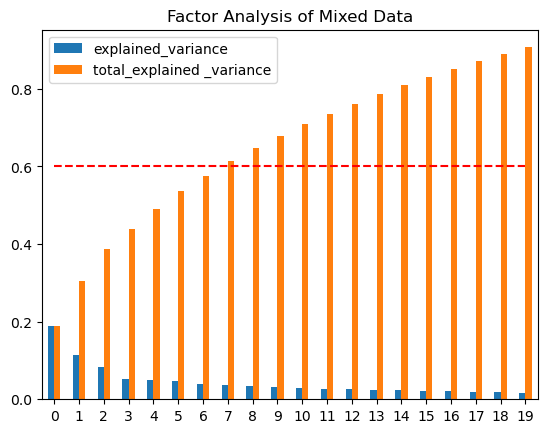

In [227]:
exp_var.plot.bar()
plt.plot([0,19], [0.6,0.6], 'r--')
plt.xticks(rotation = 0)
plt.title('Factor Analysis of Mixed Data');

#plt.savefig('Exp_Var', dpi = 200)

In [222]:
# randomely sample 100 points from data
num = df.shape[0]
index = rng.integers(low = 0, high = num, size = 100)
sample = df.iloc[index, :]
sample.shape

(100, 33)

In [177]:
# first 2 PC
famd2 = prince.FAMD(
     n_components=2,  
     n_iter=3,
     copy=True,
     check_input=True,
     engine='auto',       
     random_state=rs)

famd2 = famd.fit(s) 

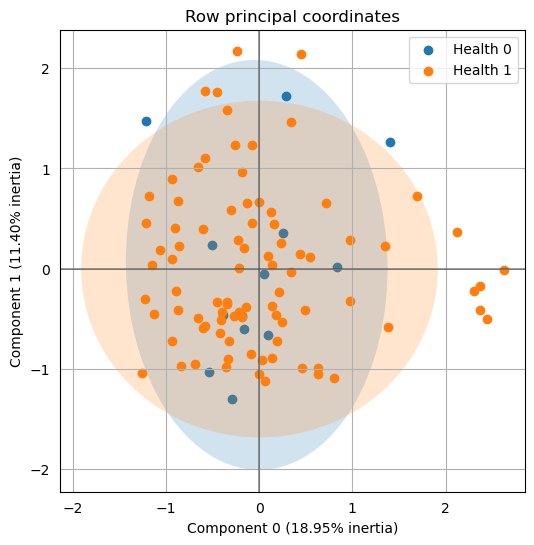

In [184]:
# plot first 2 PC
ax = famd2.plot_row_coordinates(
     sample,
     ax=None,
     figsize=(6, 6),
     x_component=0,
     y_component=1,
     labels=None,
     color_labels=['Health {}'.format(t) for t in sample['health']],
     ellipse_outline=False,
     ellipse_fill=True,
     show_points=True
 )

ax.get_figure();

### Feature Selection (Lasso logistic regression)

In [164]:
# one hot encoding on categorical variables
X_enc = pd.get_dummies(X, drop_first = True) 
X_enc.columns

Index(['tree_dbh', 'Latitude', 'longitude', 'curb_loc_OnCurb',
       'spc_common_Japanese zelkova', 'spc_common_London planetree',
       'spc_common_Norway maple', 'spc_common_Sophora', 'spc_common_cherry',
       'spc_common_ginkgo', 'spc_common_honeylocust',
       'spc_common_littleleaf linden', 'spc_common_pin oak', 'steward_3or4',
       'steward_4orMore', 'steward_None', 'guards_Helpful', 'guards_None',
       'guards_Unsure', 'sidewalk_NoDamage', 'user_type_TreesCount Staff',
       'user_type_Volunteer', 'root_stone_Yes', 'root_grate_Yes',
       'root_other_Yes', 'trnk_wire_Yes', 'trnk_light_Yes', 'trnk_other_Yes',
       'brnch_ligh_Yes', 'brnch_shoe_Yes', 'brnch_othe_Yes',
       'boroname_Brooklyn', 'boroname_Manhattan', 'boroname_Queens',
       'boroname_Staten Island'],
      dtype='object')

In [165]:
# Standardize numeric features
X_enc['tree_dbh'] = (X_enc['tree_dbh'] - X_enc['tree_dbh'].mean())/X_enc['tree_dbh'].std()
X_enc['Latitude'] = (X_enc['Latitude'] - X_enc['Latitude'].mean())/X_enc['Latitude'].std()
X_enc['longitude'] = (X_enc['longitude'] - X_enc['longitude'].mean())/X_enc['longitude'].std()

In [166]:
X_enc.describe()

,tree_dbh,Latitude,longitude,curb_loc_OnCurb,spc_common_Japanese zelkova,spc_common_London planetree,spc_common_Norway maple,spc_common_Sophora,spc_common_cherry,spc_common_ginkgo,...,trnk_wire_Yes,trnk_light_Yes,trnk_other_Yes,brnch_ligh_Yes,brnch_shoe_Yes,brnch_othe_Yes,boroname_Brooklyn,boroname_Manhattan,boroname_Queens,boroname_Staten Island
count,4.261900e+05,4.261900e+05,4.261900e+05,426190.000000,426190.000000,426190.000000,426190.000000,426190.000000,426190.000000,426190.000000,...,426190.000000,426190.000000,426190.000000,426190.000000,426190.000000,426190.000000,426190.000000,426190.000000,426190.000000,426190.000000
mean,-1.051951e-14,8.129957e-12,-1.573781e-11,0.962015,0.068650,0.204162,0.080220,0.045374,0.068681,0.049318,...,0.021490,0.001739,0.053190,0.100293,0.000791,0.040160,0.272327,0.111626,0.365335,0.133734
std,1.000000e+00,1.000000e+00,1.000000e+00,0.191161,0.252859,0.403089,0.271634,0.208124,0.252911,0.216532,...,0.145013,0.041661,0.224412,0.300391,0.028109,0.196336,0.445158,0.314906,0.481524,0.340366
min,-1.474556e+00,-2.315580e+00,-2.789234e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.893192e-01,-7.648504e-01,-4.743377e-01,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-2.182888e-01,-2.403113e-03,5.390216e-02,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.811538e-01,6.644076e-01,7.142811e-01,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,3.484298e+01,2.380047e+00,1.850467e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [133]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size = 0.2, stratify = y, random_state = rs)

In [134]:
np.round(np.logspace(-3, 1, 5), 2)

array([ 0.  ,  0.01,  0.1 ,  1.  , 10.  ])

In [135]:
# model tuning for the best level of l1 regularization
lr_model = LogisticRegression(penalty='l1', solver='liblinear', random_state = rs)
param = {'C': np.logspace(-3, 1, 5)}
param

{'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])}

In [136]:
# grid search 
lasso_gs = GridSearchCV(
    estimator = lr_model,
    param_grid = param, 
    scoring = 'f1_macro', 
    n_jobs = -1)
lasso_gs.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(penalty='l1', random_state=18962882,
                                          solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])},
             scoring='f1_macro')

In [137]:
# best C - 10 
lasso_gs.best_params_

{'C': 10.0}

In [155]:
# logistic regression - trying a higher degree of regularization to have sparse betas
# 1 -- 0.51
# 0.1 -- 0.51
# 0.01 -- 0.505
# 0.005 -- 0.502
# 0.004 -- 0.501
# 0.0035 -- 0.5
lr = LogisticRegression(penalty='l1', solver='liblinear', random_state = rs, C = 0.0035)
lr.fit(X_train, y_train)

LogisticRegression(C=0.0035, penalty='l1', random_state=18962882,
                   solver='liblinear')

In [156]:
# Best F1 - 0.51
y_pred_lr = lr.predict(X_test)
lr_f1 = f1_score(y_test, y_pred_lr, average='macro')
print(f'logistic regression F1 score: {lr_f1:.3f}')

logistic regression F1 score: 0.500


In [157]:
# betas
lr_betas = pd.Series(lr.coef_[0], index = X_train.columns)
lr_betas['Intercept'] = lr.intercept_[0]
lr_betas

tree_dbh                        0.350996
Latitude                        0.107866
longitude                       0.000000
curb_loc_OnCurb                 0.071852
spc_common_Japanese zelkova     0.264369
spc_common_London planetree    -0.237215
spc_common_Norway maple        -1.164909
spc_common_Sophora              0.000000
spc_common_cherry               0.069305
spc_common_ginkgo               0.000000
spc_common_honeylocust          0.182437
spc_common_littleleaf linden   -0.134614
spc_common_pin oak              0.000000
steward_3or4                    0.000000
steward_4orMore                 0.000000
steward_None                    0.000000
guards_Helpful                  0.154411
guards_None                     0.052793
guards_Unsure                   0.000000
sidewalk_NoDamage               0.000000
user_type_TreesCount Staff     -0.049139
user_type_Volunteer             0.000000
root_stone_Yes                 -0.177995
root_grate_Yes                  0.000000
root_other_Yes  

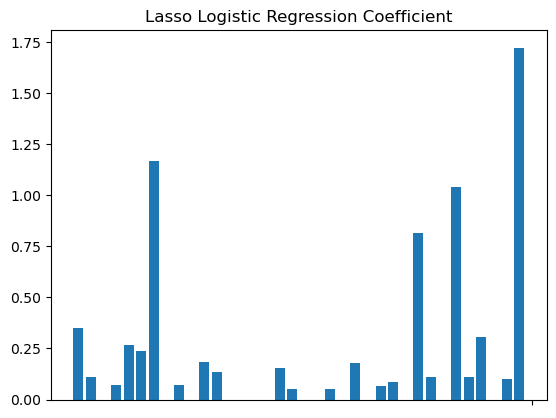

In [159]:
plt.bar(lr_betas.index, abs(lr_betas))
plt.xticks('')
plt.title('Lasso Logistic Regression Coefficient');

In [158]:
# Selected Betas
lr_betas[abs(lr_betas) > 0.00001]

tree_dbh                        0.350996
Latitude                        0.107866
curb_loc_OnCurb                 0.071852
spc_common_Japanese zelkova     0.264369
spc_common_London planetree    -0.237215
spc_common_Norway maple        -1.164909
spc_common_cherry               0.069305
spc_common_honeylocust          0.182437
spc_common_littleleaf linden   -0.134614
guards_Helpful                  0.154411
guards_None                     0.052793
user_type_TreesCount Staff     -0.049139
root_stone_Yes                 -0.177995
root_other_Yes                 -0.067082
trnk_wire_Yes                  -0.087507
trnk_other_Yes                 -0.815401
brnch_ligh_Yes                 -0.109876
brnch_othe_Yes                 -1.041041
boroname_Brooklyn               0.109301
boroname_Manhattan             -0.306631
boroname_Staten Island          0.098646
Intercept                       1.721141
dtype: float64

In [102]:
# selected features + target
features = ['health', 'tree_dbh','Latitude','curb_loc','spc_common','guards','user_type',
            'root_stone','root_other','trnk_wire','trnk_other','brnch_ligh','brnch_othe','boroname']

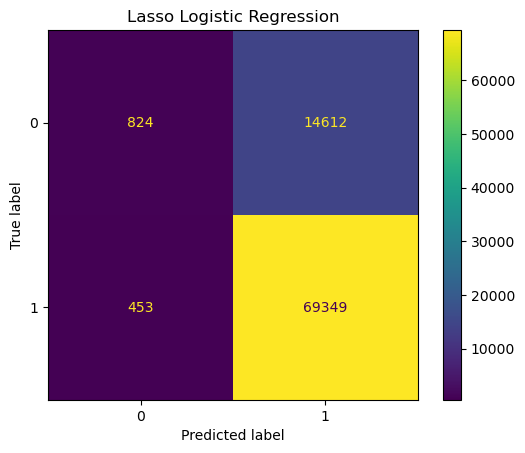

In [160]:
# confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix = cm_lr)
disp_lr.plot()
plt.title('Lasso Logistic Regression');

In [185]:
# Subset features into new df
sub = df[features]
print(sub.shape)
sub.head()

(426190, 14)


,health,tree_dbh,Latitude,curb_loc,spc_common,guards,user_type,root_stone,root_other,trnk_wire,trnk_other,brnch_ligh,brnch_othe,boroname
1,0,21,40.794111,OnCurb,pin oak,None,TreesCount Staff,Yes,No,No,No,No,No,Queens
2,1,3,40.717581,OnCurb,honeylocust,None,Volunteer,No,No,No,No,No,No,Brooklyn
3,1,10,40.713537,OnCurb,honeylocust,None,Volunteer,Yes,No,No,No,No,No,Brooklyn
5,1,11,40.770046,OnCurb,honeylocust,Helpful,Volunteer,No,No,No,No,No,No,Manhattan
6,1,11,40.770210,OnCurb,honeylocust,Helpful,Volunteer,No,No,No,No,No,No,Manhattan


### save new data frame

In [186]:
#sub.to_pickle('sub')